#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

# Part 1, perfect features

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

In [3]:
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
cats = pd.read_csv('item_categories.csv')
train = pd.read_csv('sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('test.csv').set_index('ID')

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

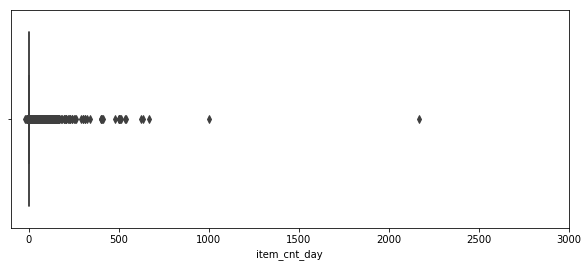

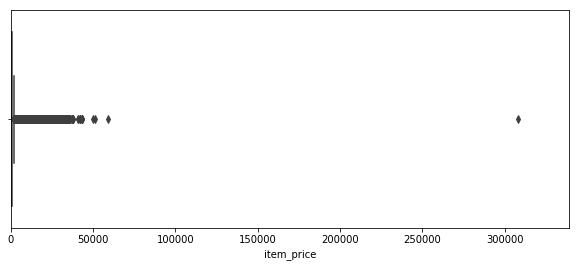

In [4]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [5]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [6]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [7]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype 
in its name.

In [8]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [9]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [10]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

21.306561708450317

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [11]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [12]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

11.450082540512085

## Test set
To use time tricks append test pairs to the matrix.

In [13]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [14]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.1727290153503418

## Shops/Items/Cats features

In [15]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

10.038388729095459

## Traget lags

In [16]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [17]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,4,5,6,7,8,9,10,11,12], 'item_cnt_month')
time.time() - ts

173.63204526901245

## Mean encoded features

In [18]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

22.619672536849976

In [19]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6,7,8,9,10,11,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

202.63017678260803

In [20]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6,7,8,9,10,11,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

207.1258201599121

In [21]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

34.881725549697876

In [22]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

34.28597378730774

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

35.641414165496826

In [24]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

35.86189651489258

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

35.004984855651855

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

48.1858012676239

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

35.68622708320618

In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

36.3863570690155

## Trend features

Price trend for the last six months.

In [29]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6,7,8,9,10,11,12]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
#matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
for i in lags:
    matrix['delta_price_lag_'+str(i)] = matrix['delta_price_lag_'+str(i)].astype(np.float16)
    matrix['delta_price_lag_'+str(i)].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    #fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

237.3567497730255

Last month shop revenue trend

In [30]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

48.85731077194214

## Special features

In [31]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [32]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. For each row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [33]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

2342.6452503204346

In [34]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

1538.5925340652466

Months since the first sale for each shop/item pair and for item only.

In [35]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

3.4961798191070557

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [36]:
#matrix = matrix[matrix.date_block_num > 11]

Producing lags brings a lot of nulls.

In [37]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

22.132708311080933

In [38]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_5', 'item_cnt_month_lag_6', 'item_cnt_month_lag_7',
       'item_cnt_month_lag_8', 'item_cnt_month_lag_9', 'item_cnt_month_lag_10',
       'item_cnt_month_lag_11', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_4', 'date_item_avg_item_cnt_lag_5',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_7',
       'date_item_avg_item_cnt_lag_8', 'date_item_avg_item_cnt_lag_9',
       'date_item_avg_item_cnt_lag_10', 'date_item_avg_item_cnt_lag_11',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_av

In [39]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 72 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_4                    float16
item_cnt_month_lag_5                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_7                    float16
item_cnt_month_lag_8                    float16
item_cnt_month_lag_9                    float16
item_cnt_month_lag_10                   float16
item_cnt_month_lag_11                   f

In [40]:
matrix.to_pickle('./submission/data_v2.pkl')
#del matrix
#del cache
#del group
#del items
#del shops
#del cats
#del train
# leave test for submission
#gc.collect();

# Part 2, xgboost

In [3]:
data = pd.read_pickle('./submission/data_v2.pkl')

Select perfect features

In [4]:
data = data[data.date_block_num > 7]
data = data[['date_block_num', 
             'shop_id', 
             'item_id', 
             'item_cnt_month',
             'city_code',
             'item_category_id',
             'type_code',
             'subtype_code',
             'item_cnt_month_lag_1',
             'item_cnt_month_lag_2',
             'item_cnt_month_lag_3',
             'item_cnt_month_lag_4',
             'item_cnt_month_lag_5', 
             'item_cnt_month_lag_6', 
             #'item_cnt_month_lag_7',
             #'item_cnt_month_lag_8', 
             #'item_cnt_month_lag_9', 
             #'item_cnt_month_lag_10',
             #'item_cnt_month_lag_11', 
             #'item_cnt_month_lag_12',
             'date_avg_item_cnt_lag_1', 
             'date_item_avg_item_cnt_lag_1',
             'date_item_avg_item_cnt_lag_2',
             'date_item_avg_item_cnt_lag_3',
             'date_item_avg_item_cnt_lag_4',
             'date_item_avg_item_cnt_lag_5',
             'date_item_avg_item_cnt_lag_6',
             #'date_item_avg_item_cnt_lag_7',
             #'date_item_avg_item_cnt_lag_8', 
             #'date_item_avg_item_cnt_lag_9',
             #'date_item_avg_item_cnt_lag_10', 
             #'date_item_avg_item_cnt_lag_11',
             #'date_item_avg_item_cnt_lag_12',
             'date_shop_avg_item_cnt_lag_1',
             'date_shop_avg_item_cnt_lag_2', 
             'date_shop_avg_item_cnt_lag_3',
             'date_shop_avg_item_cnt_lag_4', 
             'date_shop_avg_item_cnt_lag_5',
             'date_shop_avg_item_cnt_lag_6', 
             #'date_shop_avg_item_cnt_lag_7',
             #'date_shop_avg_item_cnt_lag_8', 
             #'date_shop_avg_item_cnt_lag_9',
             #'date_shop_avg_item_cnt_lag_10',
             #'date_shop_avg_item_cnt_lag_11',
             #'date_shop_avg_item_cnt_lag_12', 
             'date_cat_avg_item_cnt_lag_1',
             'date_shop_cat_avg_item_cnt_lag_1', 
             'date_shop_type_avg_item_cnt_lag_1',
             'date_shop_subtype_avg_item_cnt_lag_1', 
             'date_city_avg_item_cnt_lag_1',
             'date_item_city_avg_item_cnt_lag_1',
             'date_type_avg_item_cnt_lag_1',
             'date_subtype_avg_item_cnt_lag_1', 
             'delta_price_lag_1',
             'delta_price_lag_2', 
             'delta_price_lag_3',
             'delta_price_lag_4',
             'delta_price_lag_5', 
             'delta_price_lag_6', 
             #'delta_price_lag_7',
             #'delta_price_lag_8',
             #'delta_price_lag_9', 
             #'delta_price_lag_10',
             #'delta_price_lag_11',
             #'delta_price_lag_12',
             'delta_revenue_lag_1',
             'month', 
             'days', 
             'item_shop_last_sale',
             'item_last_sale',
             'item_shop_first_sale', 
             'item_first_sale']]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [5]:
train = shuffle(data[data.date_block_num <= 33])
s = np.ceil(len(train) * 0.8).astype(int)

X_train = train[0:s].drop(['item_cnt_month'], axis=1)
Y_train = train[0:s]['item_cnt_month']

X_valid = train[s:len(train)].drop(['item_cnt_month'], axis=1)
Y_valid = train[s:len(train)]['item_cnt_month']

X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
import gc
del data
gc.collect();

In [7]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=3000,
    n_jobs=12,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

/home/emvok13/datuiji/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/emvok13/datuiji/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.1912	validation_1-rmse:1.19701
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.14308	validation_1-rmse:1.14885
[2]	validation_0-rmse:1.1021	validation_1-rmse:1.10793
[3]	validation_0-rmse:1.06771	validation_1-rmse:1.07357
[4]	validation_0-rmse:1.03804	validation_1-rmse:1.04408
[5]	validation_0-rmse:1.01326	validation_1-rmse:1.01947
[6]	validation_0-rmse:0.992485	validation_1-rmse:0.998828
[7]	validation_0-rmse:0.974747	validation_1-rmse:0.981179
[8]	validation_0-rmse:0.960462	validation_1-rmse:0.967066
[9]	validation_0-rmse:0.947091	validation_1-rmse:0.953716
[10]	validation_0-rmse:0.936647	validation_1-rmse:0.94344
[11]	validation_0-rmse:0.926779	validation_1-rmse:0.933597
[12]	validation_0-rmse:0.918206	validation_1-rmse:0.925174
[13]	validation_0-rmse:0.910921	validation_1-rmse:0.91796
[14]	validation_0-rmse:0.905212	validatio

[137]	validation_0-rmse:0.824866	validation_1-rmse:0.840138
[138]	validation_0-rmse:0.824742	validation_1-rmse:0.840049
[139]	validation_0-rmse:0.824157	validation_1-rmse:0.839527
[140]	validation_0-rmse:0.823873	validation_1-rmse:0.839296
[141]	validation_0-rmse:0.823101	validation_1-rmse:0.83859
[142]	validation_0-rmse:0.822992	validation_1-rmse:0.838521
[143]	validation_0-rmse:0.82288	validation_1-rmse:0.838448
[144]	validation_0-rmse:0.822781	validation_1-rmse:0.838391
[145]	validation_0-rmse:0.822624	validation_1-rmse:0.838322
[146]	validation_0-rmse:0.821951	validation_1-rmse:0.837742
[147]	validation_0-rmse:0.821788	validation_1-rmse:0.837606
[148]	validation_0-rmse:0.821702	validation_1-rmse:0.837557
[149]	validation_0-rmse:0.821598	validation_1-rmse:0.837512
[150]	validation_0-rmse:0.821457	validation_1-rmse:0.837407
[151]	validation_0-rmse:0.820755	validation_1-rmse:0.836802
[152]	validation_0-rmse:0.820607	validation_1-rmse:0.836698
[153]	validation_0-rmse:0.820387	validatio

[274]	validation_0-rmse:0.805338	validation_1-rmse:0.826172
[275]	validation_0-rmse:0.805264	validation_1-rmse:0.826124
[276]	validation_0-rmse:0.80517	validation_1-rmse:0.826106
[277]	validation_0-rmse:0.805127	validation_1-rmse:0.826093
[278]	validation_0-rmse:0.804974	validation_1-rmse:0.825962
[279]	validation_0-rmse:0.804925	validation_1-rmse:0.825925
[280]	validation_0-rmse:0.804658	validation_1-rmse:0.82571
[281]	validation_0-rmse:0.804583	validation_1-rmse:0.825683
[282]	validation_0-rmse:0.804529	validation_1-rmse:0.825671
[283]	validation_0-rmse:0.803829	validation_1-rmse:0.825034
[284]	validation_0-rmse:0.803789	validation_1-rmse:0.825032
[285]	validation_0-rmse:0.8037	validation_1-rmse:0.824968
[286]	validation_0-rmse:0.803656	validation_1-rmse:0.824964
[287]	validation_0-rmse:0.803475	validation_1-rmse:0.82482
[288]	validation_0-rmse:0.803392	validation_1-rmse:0.82473
[289]	validation_0-rmse:0.803084	validation_1-rmse:0.824478
[290]	validation_0-rmse:0.803005	validation_1-

[412]	validation_0-rmse:0.793533	validation_1-rmse:0.819306
[413]	validation_0-rmse:0.793476	validation_1-rmse:0.819302
[414]	validation_0-rmse:0.793348	validation_1-rmse:0.819202
[415]	validation_0-rmse:0.793314	validation_1-rmse:0.819191
[416]	validation_0-rmse:0.793282	validation_1-rmse:0.819189
[417]	validation_0-rmse:0.792896	validation_1-rmse:0.818873
[418]	validation_0-rmse:0.792839	validation_1-rmse:0.818846
[419]	validation_0-rmse:0.792704	validation_1-rmse:0.818749
[420]	validation_0-rmse:0.792686	validation_1-rmse:0.818758
[421]	validation_0-rmse:0.79265	validation_1-rmse:0.81875
[422]	validation_0-rmse:0.79261	validation_1-rmse:0.818745
[423]	validation_0-rmse:0.792496	validation_1-rmse:0.818689
[424]	validation_0-rmse:0.792431	validation_1-rmse:0.818661
[425]	validation_0-rmse:0.792374	validation_1-rmse:0.818632
[426]	validation_0-rmse:0.792328	validation_1-rmse:0.81861
[427]	validation_0-rmse:0.792164	validation_1-rmse:0.818509
[428]	validation_0-rmse:0.792116	validation_

[550]	validation_0-rmse:0.784037	validation_1-rmse:0.81395
[551]	validation_0-rmse:0.78402	validation_1-rmse:0.813945
[552]	validation_0-rmse:0.783866	validation_1-rmse:0.813819
[553]	validation_0-rmse:0.783741	validation_1-rmse:0.81374
[554]	validation_0-rmse:0.783715	validation_1-rmse:0.813731
[555]	validation_0-rmse:0.783689	validation_1-rmse:0.81372
[556]	validation_0-rmse:0.783657	validation_1-rmse:0.813715
[557]	validation_0-rmse:0.783631	validation_1-rmse:0.813707
[558]	validation_0-rmse:0.783391	validation_1-rmse:0.81349
[559]	validation_0-rmse:0.783353	validation_1-rmse:0.813483
[560]	validation_0-rmse:0.783269	validation_1-rmse:0.813451
[561]	validation_0-rmse:0.783201	validation_1-rmse:0.813415
[562]	validation_0-rmse:0.783178	validation_1-rmse:0.813422
[563]	validation_0-rmse:0.783158	validation_1-rmse:0.813421
[564]	validation_0-rmse:0.78314	validation_1-rmse:0.813421
[565]	validation_0-rmse:0.783119	validation_1-rmse:0.813419
[566]	validation_0-rmse:0.78307	validation_1-r

[688]	validation_0-rmse:0.775799	validation_1-rmse:0.809437
[689]	validation_0-rmse:0.775694	validation_1-rmse:0.809335
[690]	validation_0-rmse:0.775676	validation_1-rmse:0.809333
[691]	validation_0-rmse:0.77565	validation_1-rmse:0.80933
[692]	validation_0-rmse:0.775616	validation_1-rmse:0.809317
[693]	validation_0-rmse:0.775573	validation_1-rmse:0.809298
[694]	validation_0-rmse:0.775539	validation_1-rmse:0.809276
[695]	validation_0-rmse:0.775504	validation_1-rmse:0.809263
[696]	validation_0-rmse:0.775419	validation_1-rmse:0.809185
[697]	validation_0-rmse:0.775352	validation_1-rmse:0.80916
[698]	validation_0-rmse:0.775328	validation_1-rmse:0.809165
[699]	validation_0-rmse:0.775275	validation_1-rmse:0.809146
[700]	validation_0-rmse:0.775239	validation_1-rmse:0.809139
[701]	validation_0-rmse:0.775216	validation_1-rmse:0.809138
[702]	validation_0-rmse:0.775186	validation_1-rmse:0.809131
[703]	validation_0-rmse:0.775149	validation_1-rmse:0.809105
[704]	validation_0-rmse:0.775132	validation

[826]	validation_0-rmse:0.769587	validation_1-rmse:0.806673
[827]	validation_0-rmse:0.769562	validation_1-rmse:0.806663
[828]	validation_0-rmse:0.769539	validation_1-rmse:0.806663
[829]	validation_0-rmse:0.769503	validation_1-rmse:0.806636
[830]	validation_0-rmse:0.769491	validation_1-rmse:0.806645
[831]	validation_0-rmse:0.769462	validation_1-rmse:0.806652
[832]	validation_0-rmse:0.769435	validation_1-rmse:0.806642
[833]	validation_0-rmse:0.76941	validation_1-rmse:0.80664
[834]	validation_0-rmse:0.76938	validation_1-rmse:0.80663
[835]	validation_0-rmse:0.769327	validation_1-rmse:0.806593
[836]	validation_0-rmse:0.769303	validation_1-rmse:0.8066
[837]	validation_0-rmse:0.769289	validation_1-rmse:0.806595
[838]	validation_0-rmse:0.769257	validation_1-rmse:0.806597
[839]	validation_0-rmse:0.769234	validation_1-rmse:0.806591
[840]	validation_0-rmse:0.769154	validation_1-rmse:0.806515
[841]	validation_0-rmse:0.769108	validation_1-rmse:0.806487
[842]	validation_0-rmse:0.769027	validation_1-

[964]	validation_0-rmse:0.763678	validation_1-rmse:0.804047
[965]	validation_0-rmse:0.763657	validation_1-rmse:0.804041
[966]	validation_0-rmse:0.763638	validation_1-rmse:0.804037
[967]	validation_0-rmse:0.763618	validation_1-rmse:0.804032
[968]	validation_0-rmse:0.763568	validation_1-rmse:0.804016
[969]	validation_0-rmse:0.763544	validation_1-rmse:0.804018
[970]	validation_0-rmse:0.763518	validation_1-rmse:0.804019
[971]	validation_0-rmse:0.763322	validation_1-rmse:0.803834
[972]	validation_0-rmse:0.763309	validation_1-rmse:0.80384
[973]	validation_0-rmse:0.76323	validation_1-rmse:0.803795
[974]	validation_0-rmse:0.763208	validation_1-rmse:0.803798
[975]	validation_0-rmse:0.763188	validation_1-rmse:0.8038
[976]	validation_0-rmse:0.76315	validation_1-rmse:0.803791
[977]	validation_0-rmse:0.763117	validation_1-rmse:0.803786
[978]	validation_0-rmse:0.76309	validation_1-rmse:0.803792
[979]	validation_0-rmse:0.763067	validation_1-rmse:0.803781
[980]	validation_0-rmse:0.762738	validation_1-

[1100]	validation_0-rmse:0.75811	validation_1-rmse:0.801388
[1101]	validation_0-rmse:0.758068	validation_1-rmse:0.801364
[1102]	validation_0-rmse:0.758041	validation_1-rmse:0.801373
[1103]	validation_0-rmse:0.757984	validation_1-rmse:0.801343
[1104]	validation_0-rmse:0.757953	validation_1-rmse:0.801333
[1105]	validation_0-rmse:0.757938	validation_1-rmse:0.801326
[1106]	validation_0-rmse:0.757903	validation_1-rmse:0.801316
[1107]	validation_0-rmse:0.757851	validation_1-rmse:0.801287
[1108]	validation_0-rmse:0.757831	validation_1-rmse:0.801274
[1109]	validation_0-rmse:0.757794	validation_1-rmse:0.801266
[1110]	validation_0-rmse:0.757766	validation_1-rmse:0.801266
[1111]	validation_0-rmse:0.757747	validation_1-rmse:0.801255
[1112]	validation_0-rmse:0.757701	validation_1-rmse:0.80124
[1113]	validation_0-rmse:0.757634	validation_1-rmse:0.801193
[1114]	validation_0-rmse:0.757606	validation_1-rmse:0.801177
[1115]	validation_0-rmse:0.757544	validation_1-rmse:0.801121
[1116]	validation_0-rmse:0

[1235]	validation_0-rmse:0.752875	validation_1-rmse:0.798913
[1236]	validation_0-rmse:0.752863	validation_1-rmse:0.798916
[1237]	validation_0-rmse:0.75282	validation_1-rmse:0.798907
[1238]	validation_0-rmse:0.752803	validation_1-rmse:0.798914
[1239]	validation_0-rmse:0.752791	validation_1-rmse:0.798911
[1240]	validation_0-rmse:0.752773	validation_1-rmse:0.798908
[1241]	validation_0-rmse:0.75273	validation_1-rmse:0.798884
[1242]	validation_0-rmse:0.752718	validation_1-rmse:0.798883
[1243]	validation_0-rmse:0.752704	validation_1-rmse:0.798879
[1244]	validation_0-rmse:0.75269	validation_1-rmse:0.798883
[1245]	validation_0-rmse:0.752674	validation_1-rmse:0.798882
[1246]	validation_0-rmse:0.752654	validation_1-rmse:0.798879
[1247]	validation_0-rmse:0.752576	validation_1-rmse:0.798817
[1248]	validation_0-rmse:0.752556	validation_1-rmse:0.798808
[1249]	validation_0-rmse:0.752452	validation_1-rmse:0.798737
[1250]	validation_0-rmse:0.752425	validation_1-rmse:0.798718
[1251]	validation_0-rmse:0.

[1370]	validation_0-rmse:0.747889	validation_1-rmse:0.79648
[1371]	validation_0-rmse:0.747877	validation_1-rmse:0.796488
[1372]	validation_0-rmse:0.747863	validation_1-rmse:0.796499
[1373]	validation_0-rmse:0.747846	validation_1-rmse:0.796487
[1374]	validation_0-rmse:0.747807	validation_1-rmse:0.796466
[1375]	validation_0-rmse:0.747797	validation_1-rmse:0.796468
[1376]	validation_0-rmse:0.747776	validation_1-rmse:0.796465
[1377]	validation_0-rmse:0.747727	validation_1-rmse:0.796437
[1378]	validation_0-rmse:0.747657	validation_1-rmse:0.7964
[1379]	validation_0-rmse:0.74765	validation_1-rmse:0.796402
[1380]	validation_0-rmse:0.747607	validation_1-rmse:0.796385
[1381]	validation_0-rmse:0.747585	validation_1-rmse:0.796391
[1382]	validation_0-rmse:0.747567	validation_1-rmse:0.796383
[1383]	validation_0-rmse:0.747453	validation_1-rmse:0.796307
[1384]	validation_0-rmse:0.747443	validation_1-rmse:0.796308
[1385]	validation_0-rmse:0.747428	validation_1-rmse:0.796312
[1386]	validation_0-rmse:0.7

[1505]	validation_0-rmse:0.744087	validation_1-rmse:0.795197
[1506]	validation_0-rmse:0.744067	validation_1-rmse:0.795193
[1507]	validation_0-rmse:0.743678	validation_1-rmse:0.794844
[1508]	validation_0-rmse:0.743665	validation_1-rmse:0.794843
[1509]	validation_0-rmse:0.743644	validation_1-rmse:0.794849
[1510]	validation_0-rmse:0.743628	validation_1-rmse:0.794849
[1511]	validation_0-rmse:0.743617	validation_1-rmse:0.79484
[1512]	validation_0-rmse:0.743594	validation_1-rmse:0.794831
[1513]	validation_0-rmse:0.743577	validation_1-rmse:0.794835
[1514]	validation_0-rmse:0.743561	validation_1-rmse:0.794838
[1515]	validation_0-rmse:0.743521	validation_1-rmse:0.794851
[1516]	validation_0-rmse:0.74348	validation_1-rmse:0.794822
[1517]	validation_0-rmse:0.743468	validation_1-rmse:0.794816
[1518]	validation_0-rmse:0.743403	validation_1-rmse:0.794785
[1519]	validation_0-rmse:0.743304	validation_1-rmse:0.79471
[1520]	validation_0-rmse:0.743274	validation_1-rmse:0.794701
[1521]	validation_0-rmse:0.

23965.067734003067

In [9]:
test  = pd.read_csv('test.csv').set_index('ID')
test.loc[test.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [10]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('./submission/xgb_submission_v9.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('./submission/xgb_train_v9.pickle', 'wb'))
pickle.dump(Y_test, open('./submission/xgb_test_v9.pickle', 'wb'))

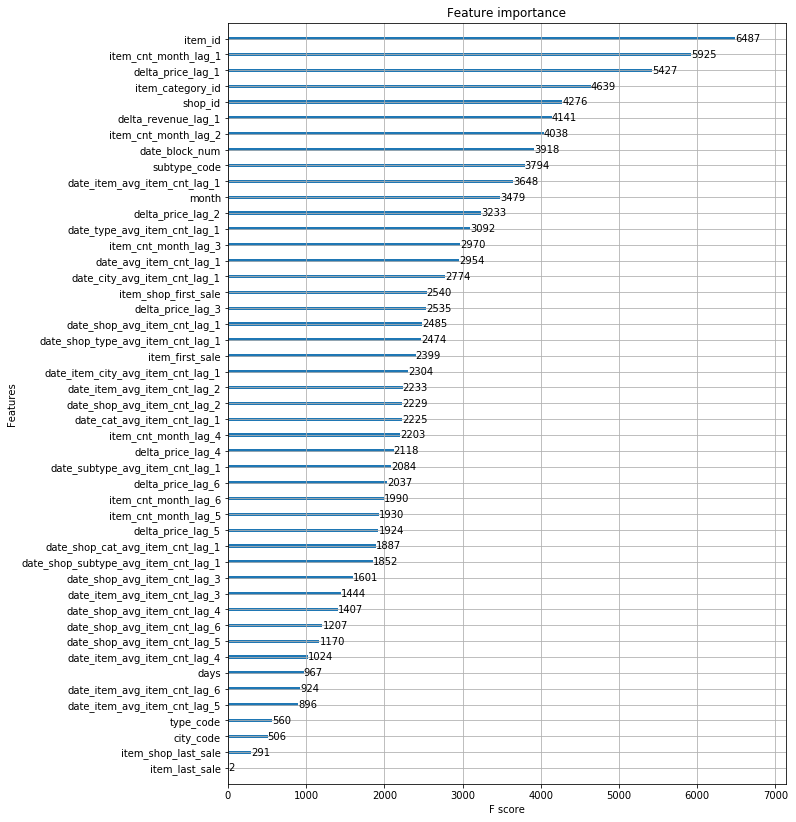

In [11]:
plot_features(model, (10,14))